In [1]:
import sys

import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from typing import *

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Window
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
import itertools

from pyspark.ml.feature import VectorAssembler, MinMaxScaler, BucketedRandomProjectionLSH
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array

from utils import *

pio.renderers.default = "iframe"

In [2]:
n_cores = 26

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

24/01/29 20:23:34 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.86.20 instead (on interface enp8s0)
24/01/29 20:23:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/29 20:23:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/29 20:23:34 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/01/29 20:23:34 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/01/29 20:23:34 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [3]:
base_path = "/data/saturation/thesis_run_20240127"
r_stat = 5
study_region_size = 2000 * 2000 / r_stat ** 2

configs_df = create_configs_df(read_configs(base_path, spark))
data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")

# State c2c nn dist in terms of r_stat and log-scale
data = data.select(
    "*",
    F.log10(F.col("center_to_center_nearest_neighbor_distance_mean") / F.lit(r_stat)).alias("log_mean_c2c_nn_dist"),
    F.log10("areal_density").alias("log_ad"),
    F.log10("n_craters_added_in_study_region").alias("log_n_craters_added_in_study_region"),
    (F.col("n_craters_in_study_region") / F.col("n_craters_added_in_study_region")).alias("information_remaining")
)

In [16]:
data_subset = data.where(
    (F.col("n_craters_added_in_study_region") > F.lit(50))
).sample(0.0025)

df = join_configs(data_subset, configs_df, spark).toPandas()

In [6]:
configs_df.toPandas().sort_values("slope")

,effective_radius_multiplier,min_rim_percentage,r_stat_multiplier,simulation_id,slope
182,1.584956,0.348604,6.714957,317,1.000465
488,1.545302,0.469838,12.513554,68,1.003086
554,1.524673,0.344355,11.281513,92,1.003589
968,1.720233,0.595578,12.032635,777,1.003728
525,1.829207,0.433165,13.989123,584,1.004682
...,...,...,...,...,...
285,1.458706,0.258751,12.967218,288,2.994595
632,1.313997,0.499783,9.377233,582,2.995268
10,1.474694,0.513892,7.738551,986,2.998889
85,1.360475,0.597560,10.084809,2,2.999350


In [17]:
def plot_log_N_and_log_NNd_for_simulation(simulation_id: int, stats_df: pd.DataFrame):
    df = stats_df[stats_df.simulation_id == simulation_id].sort_values("n_craters_added_in_study_region")
    df.head()
    
    print(df[["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]].iloc[0])
    
    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.log_mean_c2c_nn_dist, color='red', label="$log(\overline{NN_{d}})$")
    ax1.set_ylabel("$log(\overline{NN_{d}})$")
    ax1.set_xlabel("N Craters Added")
    
    ax2 = ax1.twinx()
    plt2 = ax2.plot(df.n_craters_added_in_study_region, np.log10(df.n_craters_in_study_region), color="blue", label="$log(N_{obs})$")
    ax2.set_ylabel("$log(N_{obs})$")
    
    lns = plt1 + plt2
    ax1.legend(lns, [l.get_label() for l in lns], loc=1)
    
    ax1.set_title(f"Simulation {simulation_id}")

    plt.show()

slope                           2.244523
effective_radius_multiplier     1.599996
r_stat_multiplier              12.732240
min_rim_percentage              0.346106
Name: 306833, dtype: float64


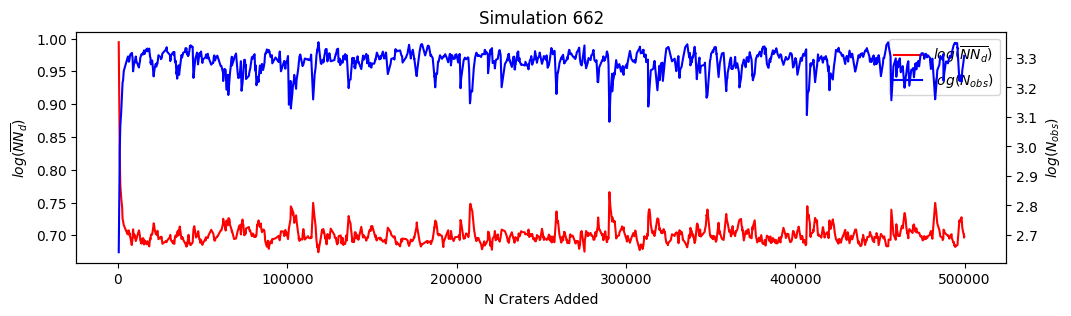

slope                          1.555726
effective_radius_multiplier    1.814095
r_stat_multiplier              6.097356
min_rim_percentage             0.476303
Name: 878334, dtype: float64


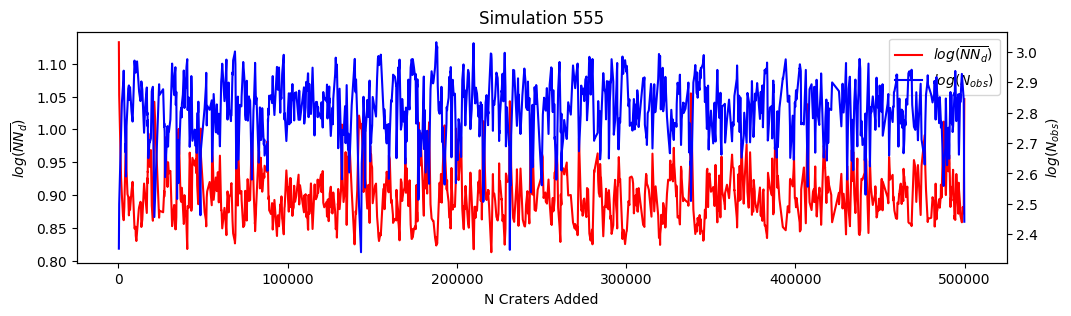

slope                          2.133639
effective_radius_multiplier    1.628639
r_stat_multiplier              7.733075
min_rim_percentage             0.475593
Name: 483453, dtype: float64


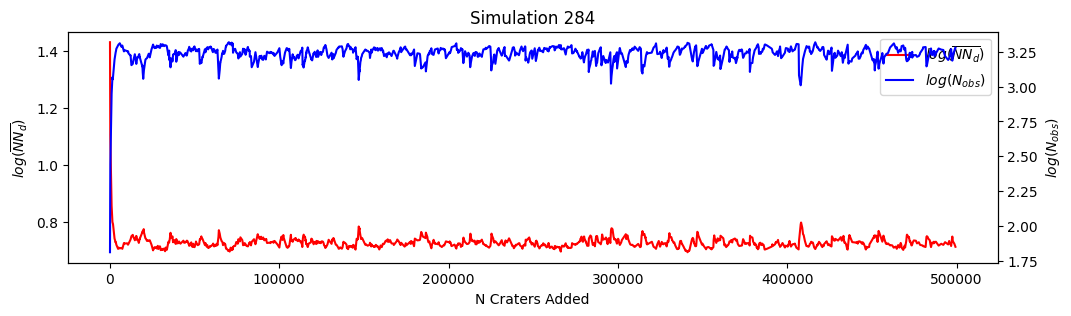

slope                          2.964459
effective_radius_multiplier    1.819289
r_stat_multiplier              7.906378
min_rim_percentage             0.618828
Name: 1228319, dtype: float64


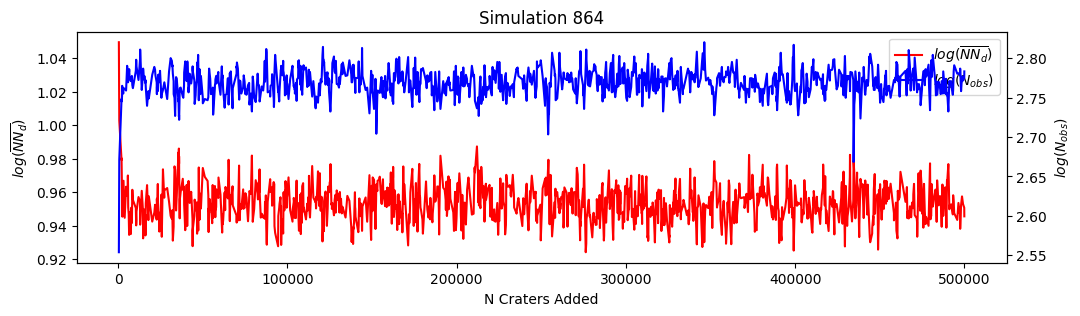

slope                          2.126771
effective_radius_multiplier    1.496317
r_stat_multiplier              7.253363
min_rim_percentage             0.606159
Name: 545458, dtype: float64


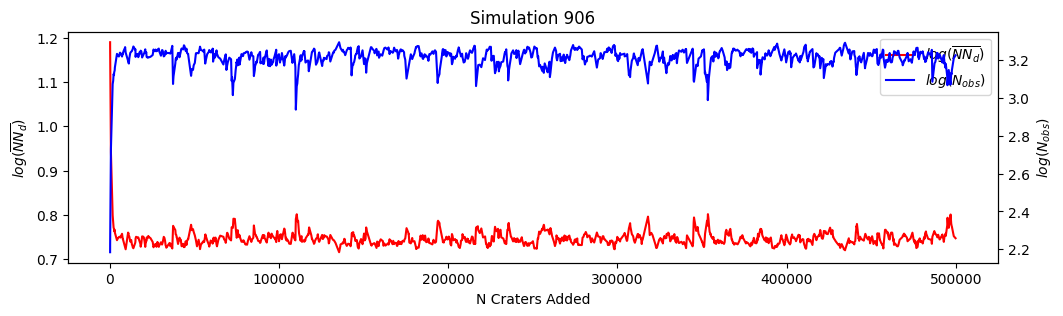

slope                          2.349460
effective_radius_multiplier    1.254905
r_stat_multiplier              8.262557
min_rim_percentage             0.598818
Name: 328097, dtype: float64


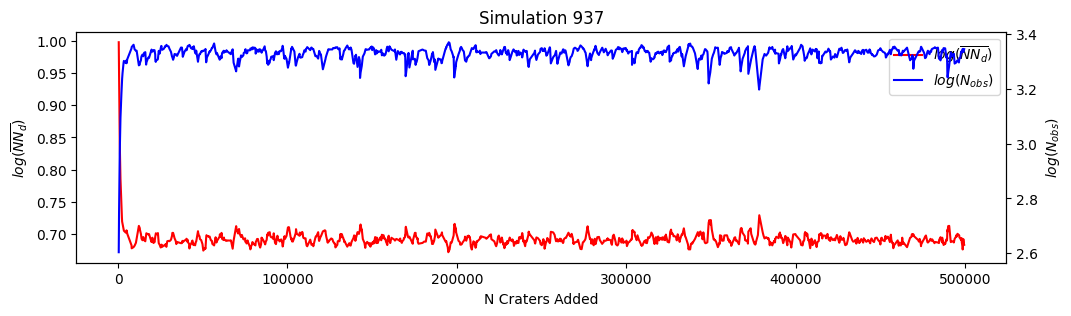

slope                           1.997590
effective_radius_multiplier     1.740495
r_stat_multiplier              12.484275
min_rim_percentage              0.385627
Name: 480446, dtype: float64


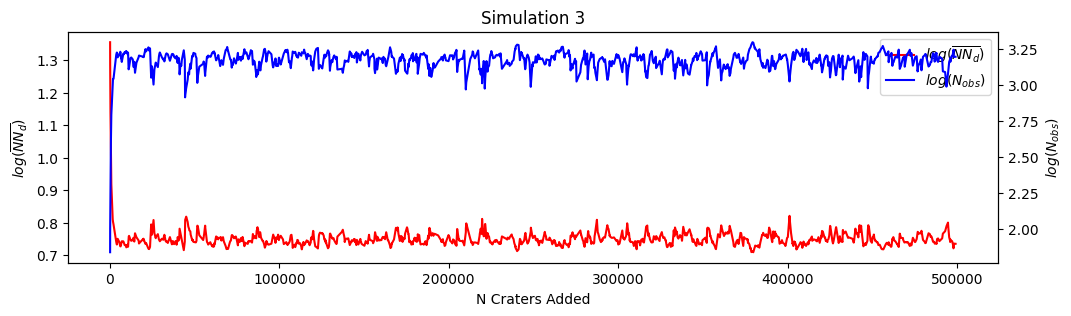

slope                           2.454509
effective_radius_multiplier     1.121932
r_stat_multiplier              11.845752
min_rim_percentage              0.640766
Name: 381959, dtype: float64


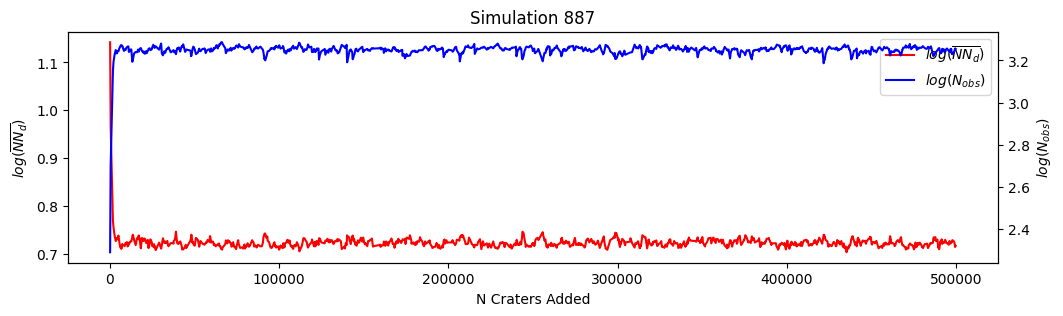

slope                           1.195753
effective_radius_multiplier     1.546052
r_stat_multiplier              14.085673
min_rim_percentage              0.737069
Name: 1107868, dtype: float64


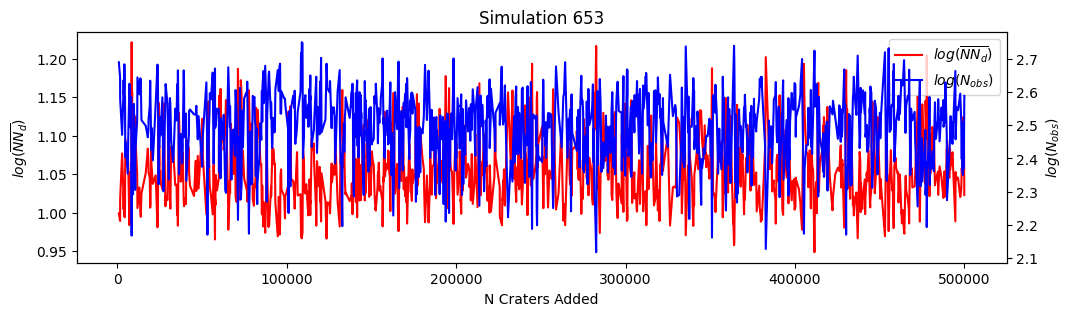

slope                           1.732356
effective_radius_multiplier     1.203444
r_stat_multiplier              11.565279
min_rim_percentage              0.460476
Name: 144871, dtype: float64


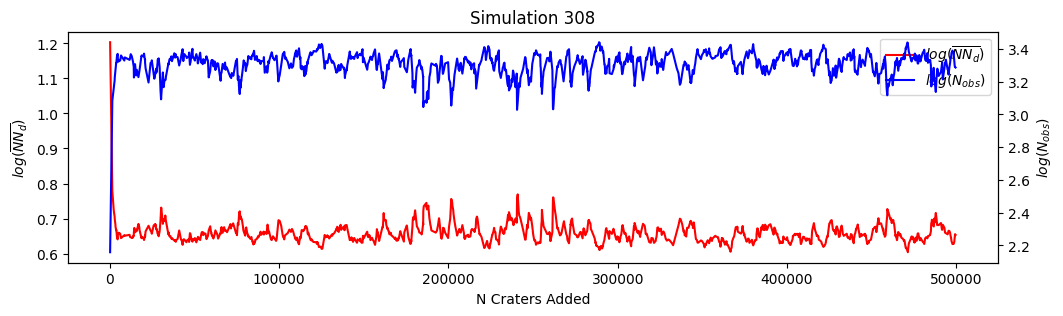

slope                           1.506995
effective_radius_multiplier     1.840741
r_stat_multiplier              11.224910
min_rim_percentage              0.576747
Name: 1047258, dtype: float64


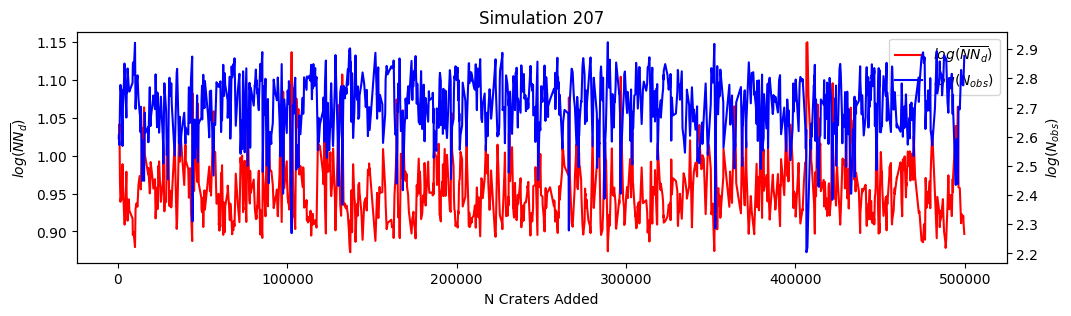

slope                          1.128242
effective_radius_multiplier    1.798706
r_stat_multiplier              9.224608
min_rim_percentage             0.274388
Name: 714586, dtype: float64


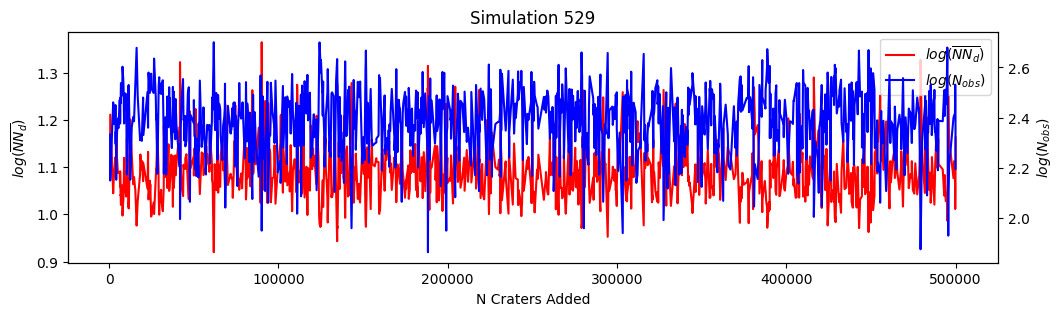

slope                          2.759883
effective_radius_multiplier    1.640847
r_stat_multiplier              6.300608
min_rim_percentage             0.462397
Name: 678259, dtype: float64


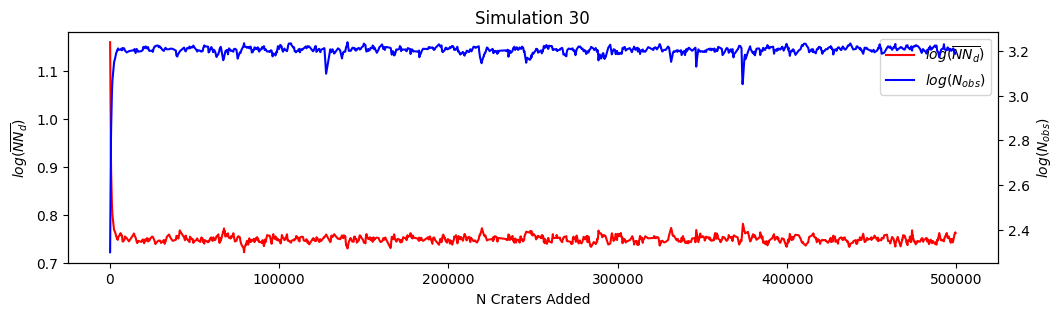

slope                           2.563616
effective_radius_multiplier     1.439870
r_stat_multiplier              11.432840
min_rim_percentage              0.683191
Name: 904037, dtype: float64


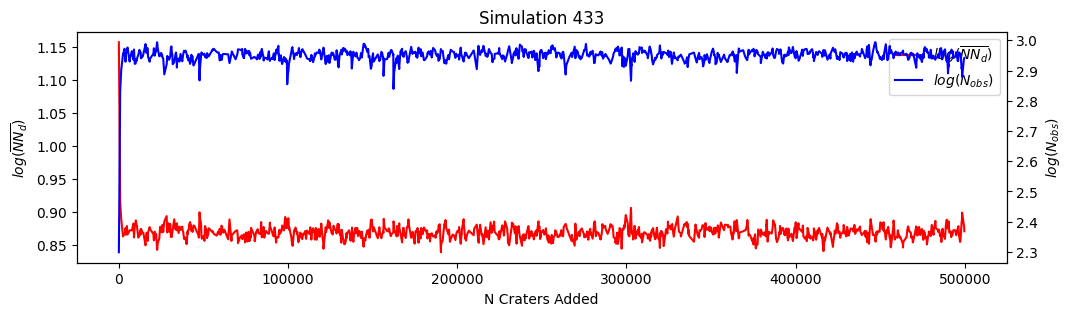

slope                           1.995663
effective_radius_multiplier     1.111218
r_stat_multiplier              11.362430
min_rim_percentage              0.654801
Name: 190053, dtype: float64


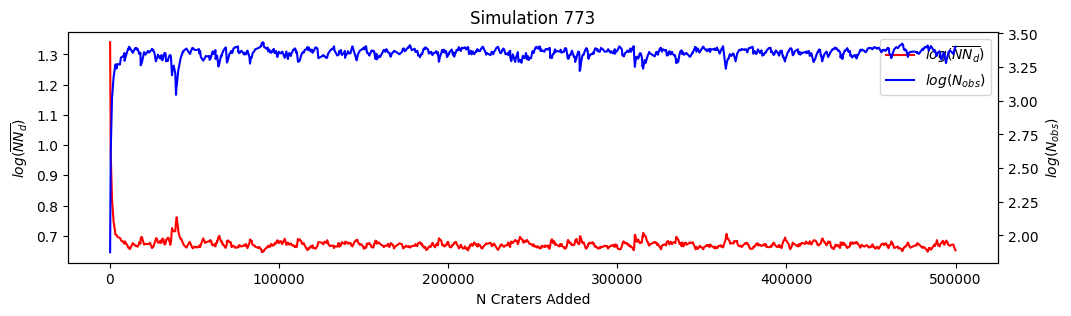

slope                          2.575597
effective_radius_multiplier    1.864602
r_stat_multiplier              6.383053
min_rim_percentage             0.462087
Name: 695024, dtype: float64


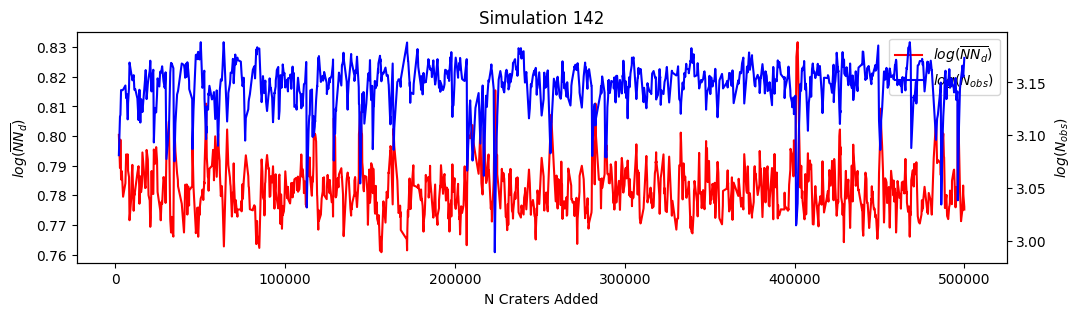

slope                          1.218294
effective_radius_multiplier    1.705437
r_stat_multiplier              9.803006
min_rim_percentage             0.438454
Name: 973490, dtype: float64


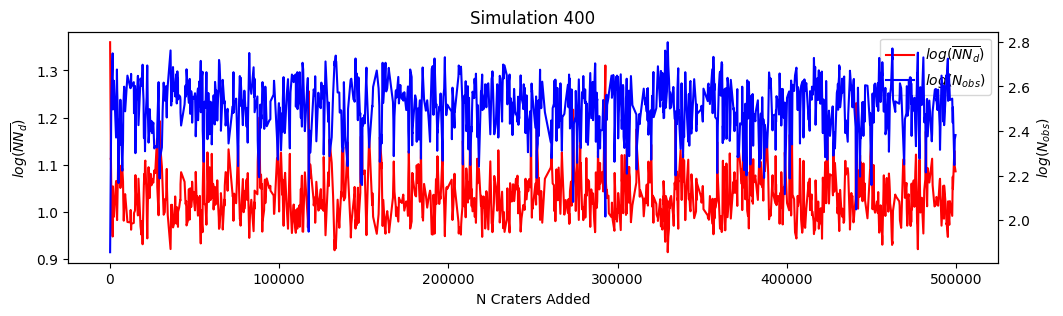

slope                          1.651687
effective_radius_multiplier    1.109886
r_stat_multiplier              9.167147
min_rim_percentage             0.721777
Name: 434118, dtype: float64


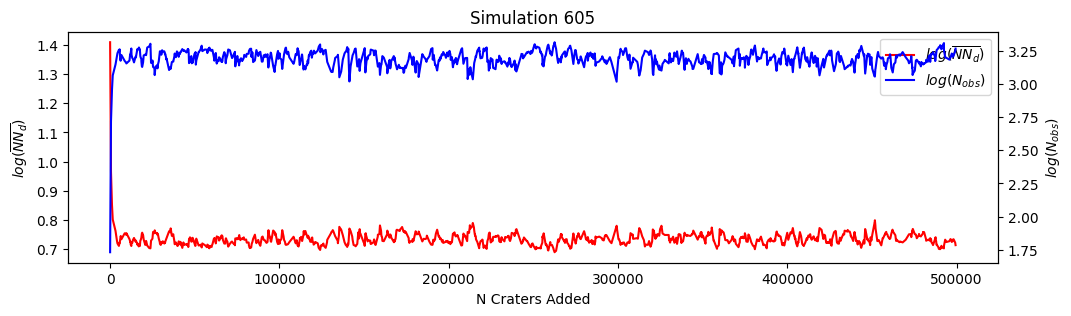

slope                           1.042720
effective_radius_multiplier     1.886073
r_stat_multiplier              10.779419
min_rim_percentage              0.537920
Name: 926299, dtype: float64


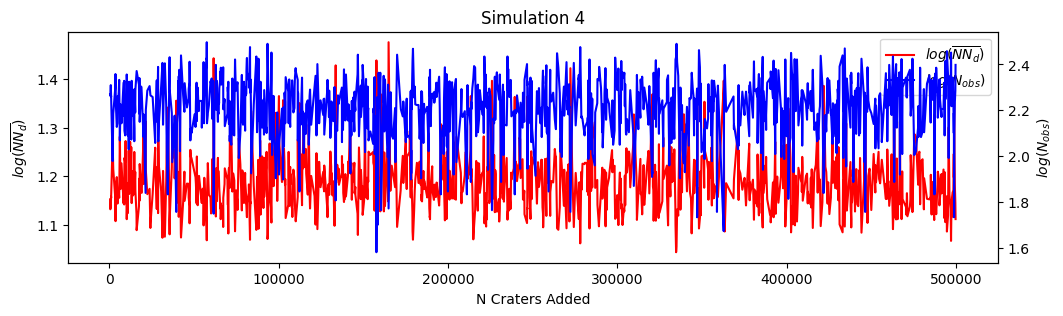

slope                          1.559510
effective_radius_multiplier    1.511742
r_stat_multiplier              9.935174
min_rim_percentage             0.266037
Name: 239234, dtype: float64


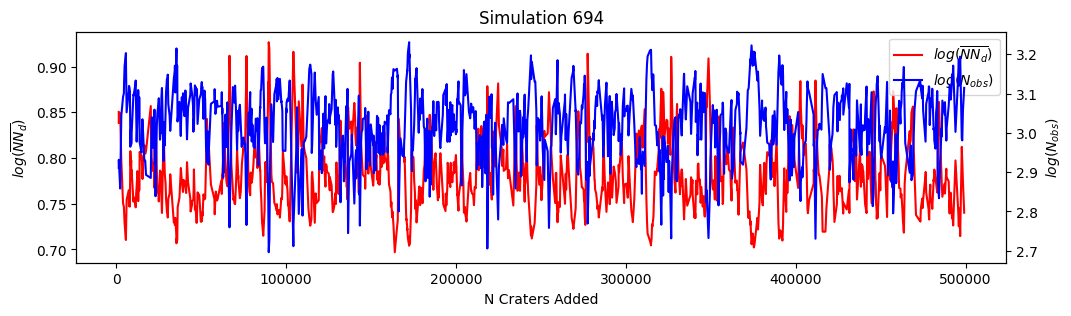

In [18]:
for sim_id in np.random.choice(df.simulation_id.drop_duplicates(), 20):
    plot_log_N_and_log_NNd_for_simulation(sim_id, df)

In [7]:
# Randomly arrange the points
# Ordering affects which points in the subsequent plots are "on top" of others
df["rnd"] = np.random.rand(df.shape[0])
df = df.sort_values("rnd")

In [8]:
fig = px.scatter(
    df,
    x="log_mean_c2c_nn_dist",
    y="log_n_craters_added_in_study_region",
    color="slope",
    hover_data=["simulation_id", "slope", "n_craters_added_in_study_region", "areal_density", "n_craters_in_study_region"],
    size_max=1,
    width=1600,
    height=600,
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(\overline{NN_d})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log_{10}(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

In [9]:
# Trying a range selector
to_show = df.copy()
to_show["slope_selector"] = ((to_show.slope - 1) * 10).astype("int") / 10 + 1
to_show = to_show.sort_values("slope_selector")
to_show["index"] = range(to_show.shape[0])
to_show["log_n_craters_in_study_region"] = np.log10(to_show.n_craters_in_study_region)
to_show["log_areal_density_overlap_2"] = np.log10(to_show.areal_density_overlap_2)

range_x = [to_show.log_mean_c2c_nn_dist.min(), to_show.log_mean_c2c_nn_dist.max()]
range_y = [to_show.log_n_craters_added_in_study_region.min(), to_show.log_n_craters_added_in_study_region.max()]

fig = px.scatter(
    to_show,
    x="log_mean_c2c_nn_dist",
    y="log_n_craters_added_in_study_region",
    color="log_ad",
    hover_data=["slope", "n_craters_added_in_study_region"],
    size_max=1,
    animation_frame="slope_selector",
    animation_group="index",
    range_x=range_x,
    range_y=range_y,
    width=1000,
    height=500
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(\overline{NN_d})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10



## Plotting single simulations

In [41]:
df = data.where(
    (F.col("n_craters_added_in_study_region") > F.lit(25))
    & (data.simulation_id == 4935)
).cache()

n_pts = 10000
n_obs = df.count()

if n_obs > n_pts:
    sample_fraction = n_pts / n_obs
    df = df.sample(sample_fraction)

pandas_df = df.toPandas()
pandas_df["log_n_craters_in_study_region"] = np.log10(pandas_df.n_craters_in_study_region)
pandas_df = pandas_df.sort_values("log_n_craters_in_study_region")

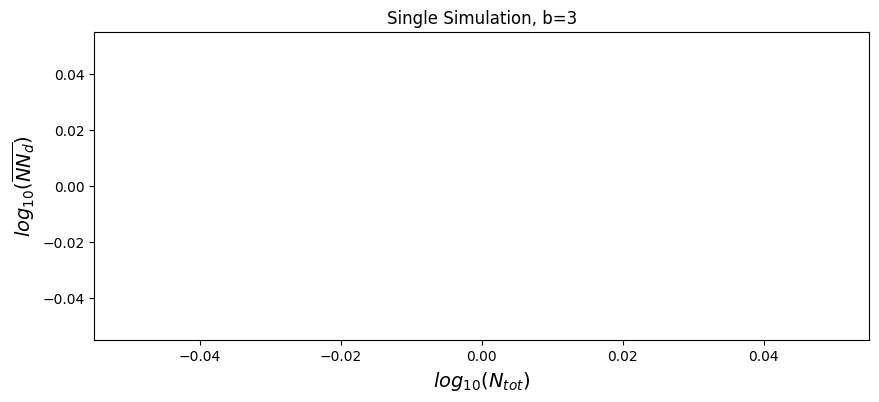

In [42]:
plt.figure(figsize=(10, 4))
plt.plot(
    # np.log10(pandas_df.n_craters_added_in_study_region),
    np.log10(pandas_df.log_n_craters_in_study_region),
    pandas_df.log_mean_c2c_nn_dist,    
)
plt.title("Single Simulation, b=3")
plt.xlabel("$log_{10}(N_{tot})$", size=14)
plt.ylabel("$log_{10}(\overline{NN_d})$", size=14)
plt.show()

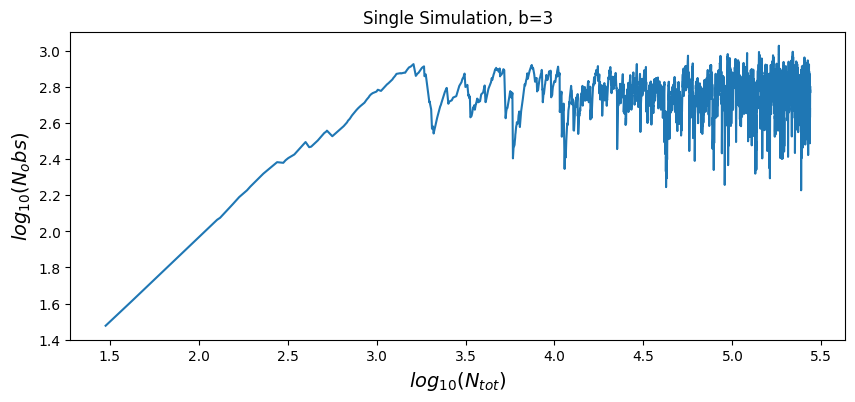

In [61]:
plt.figure(figsize=(10, 4))
plt.plot(
    np.log10(pandas_df.n_craters_added_in_study_region),
    np.log10(pandas_df.n_craters_in_study_region),
)
plt.title("Single Simulation, b=3")
plt.xlabel("$log_{10}(N_{tot})$", size=14)
plt.ylabel("$log_{10}(N_obs)$", size=14)
plt.show()